Importing libraries

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Reading the data

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

Vocab and character mapping

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Build the dataset

In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  # print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Exercises
4. I did not get around to seeing what happens when you initialize all
weights and biases to zero. Try this and train the neural net. You
might think either that 1) the network trains just fine or 2) the
network doesn't train at all, but actually it is 3) the network trains
but only partially, and achieves a pretty bad final performance.
Inspect the gradients and activations to figure out what is
happening and why the network is only partially training, and what
part is being trained exactly

In [66]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


11697


In [67]:
max_steps = 200000
batch_size = 32
lossi = []

# Containers to store gradients and activations
gradients_W1 = []
activations_h = []

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # Forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # Store activations at specific steps
    if i in [0, 50000, 100000, 150000, 199999]:
        activations_h.append(h.detach().cpu().numpy())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Store gradients at specific steps
    if i in [0, 50000, 100000, 150000, 199999]:
        gradients_W1.append(W1.grad.detach().cpu().numpy())


    # Update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2958
  10000/ 200000: 2.6793
  20000/ 200000: 2.8210
  30000/ 200000: 3.0941
  40000/ 200000: 3.0673
  50000/ 200000: 3.0884
  60000/ 200000: 2.8090
  70000/ 200000: 2.6637
  80000/ 200000: 2.6951
  90000/ 200000: 2.7917
 100000/ 200000: 2.5930
 110000/ 200000: 3.0857
 120000/ 200000: 2.8063
 130000/ 200000: 2.8613
 140000/ 200000: 2.8347
 150000/ 200000: 2.8381
 160000/ 200000: 2.8990
 170000/ 200000: 2.6623
 180000/ 200000: 2.7992
 190000/ 200000: 2.8359


In [68]:
logits[0]

tensor([ 1.9370,  1.9963, -0.5752, -0.2951,  0.1803,  1.4923, -1.6479, -0.9012,
         0.5054,  1.3282, -0.4530,  0.0917,  1.0978,  0.3513,  1.3777,  0.5573,
        -1.5076, -2.8361,  0.9912,  0.5635,  0.1831, -0.4124, -0.6070, -1.5861,
        -1.9035,  0.7552, -0.6855], grad_fn=<SelectBackward0>)

In [69]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.822659730911255
val 2.8209733963012695


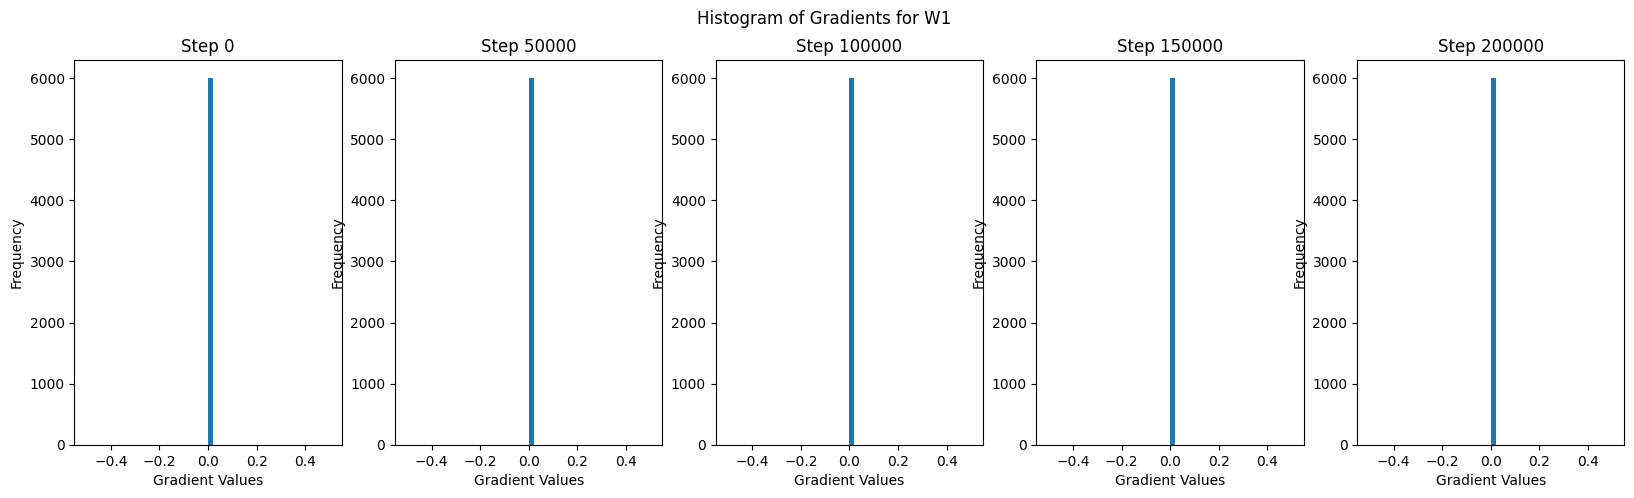

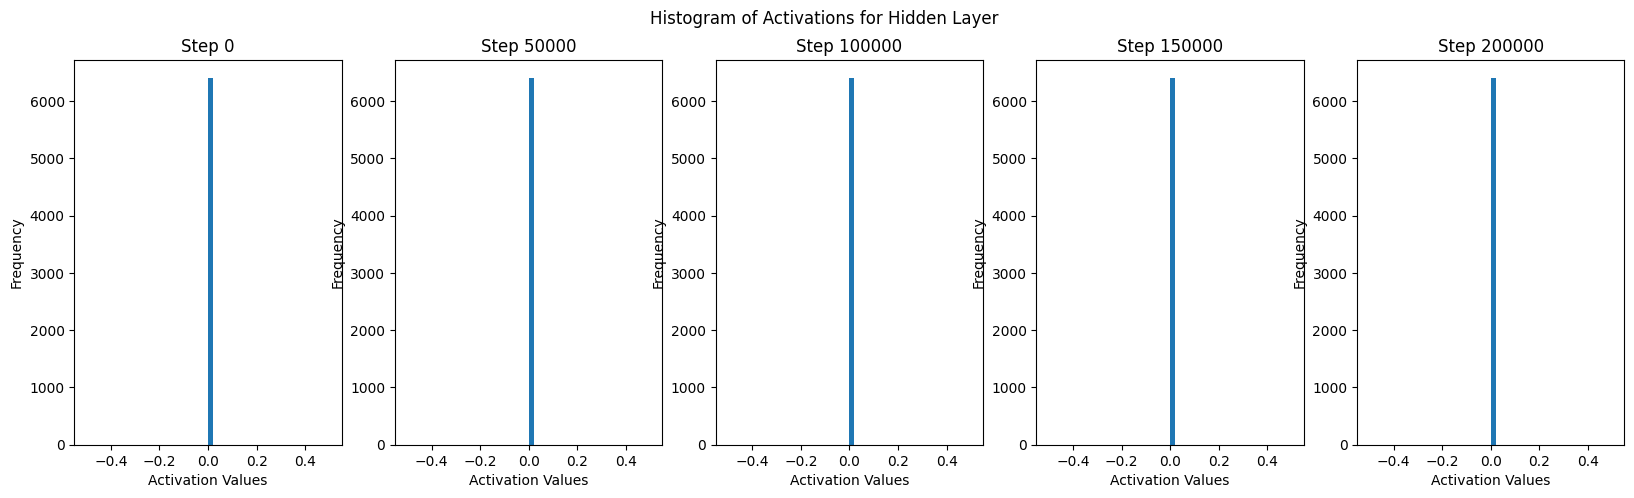

In [70]:
# Plot histograms of gradients and activations
def plot_histograms(data, title, xlabel, ylabel):
    fig, axes = plt.subplots(1, len(data), figsize=(20, 5))
    fig.suptitle(title)
    for i, (ax, d) in enumerate(zip(axes, data)):
        ax.hist(d.flatten(), bins=50)
        ax.set_title(f'Step {i * 50000}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    plt.show()

plot_histograms(gradients_W1, 'Histogram of Gradients for W1', 'Gradient Values', 'Frequency')
plot_histograms(activations_h, 'Histogram of Activations for Hidden Layer', 'Activation Values', 'Frequency')


When weights and biases are initialized to zero, there is no entropy in the logits because the output of each neuron in a layer is identical, leading to ineffective learning.

Since all weights are initialized to zero, the gradients for W1 remain zero throughout training. This prevents any updates to W1, b1, W2, and b2.

Only the embeddings C receive non-zero gradients because they are the only parameters not tied directly to the zero-initialized weights.

The activations of the hidden layer h remain zero or near-zero due to the zero-initialized weights, leading to ineffective learning.
The hidden layer h does not contribute meaningfully to the learning process since it does not change during training.

The training and validation loss is similar after training, reflecting that the network is not learning effectively.

In [71]:
#------------------------------------------------------------#

1. Tune the hyperparameters of the training to beat my best validation loss
 of 2.2

In [30]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


11697


In [31]:
max_steps = 200000
batch_size = 32
lossi = []

# Containers to store gradients and activations
gradients_W1 = []
activations_h = []

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # Forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3135
  10000/ 200000: 2.1715
  20000/ 200000: 2.3240
  30000/ 200000: 2.4010
  40000/ 200000: 1.9887
  50000/ 200000: 2.3029
  60000/ 200000: 2.4564
  70000/ 200000: 2.1249
  80000/ 200000: 2.3069
  90000/ 200000: 2.1057
 100000/ 200000: 1.8948
 110000/ 200000: 2.2326
 120000/ 200000: 1.9659
 130000/ 200000: 2.4410
 140000/ 200000: 2.2106
 150000/ 200000: 2.1795
 160000/ 200000: 1.8383
 170000/ 200000: 1.8131
 180000/ 200000: 1.9572
 190000/ 200000: 1.8002


In [32]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0367813110351562
val 2.103236198425293


In [ ]:
#---------------------------------------------------------#

2. I was not careful with the intialization of the network in this video. (1)
 What is the loss you'd get if the predicted probabilities at initialization
 were perfectly uniform? What loss do we achieve? (2) Can you tune the
 initialization to get a starting loss that is much more similar to (1)?

 3. Read the Delving Deep into Rectifiers by Kaiming He et al (***Bengio et al 2003 paper) (link above), implement and try any
 idea from the paper. Did it work?

Kaiming He initialization, named after Kaiming He, is a method specifically designed to initialize the weights of neural networks effectively. It is particularly well-suited for networks that use ReLU (Rectified Linear Unit) activations or its variants due to its ability to address the vanishing and exploding gradient problems

The scale factor used in Kaiming He initialization depends on the activation function being used:

(gain/fan_in)**0.5

For tanh non linearity, gain = 5/3

In [33]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


11697


In [34]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2560
  10000/ 200000: 2.7803
  20000/ 200000: 2.6963
  30000/ 200000: 3.1716
  40000/ 200000: 2.1269
  50000/ 200000: 2.7613
  60000/ 200000: 2.5266
  70000/ 200000: 2.1459
  80000/ 200000: 2.8482
  90000/ 200000: 2.2475
 100000/ 200000: 2.4960
 110000/ 200000: 2.3935
 120000/ 200000: 2.0816
 130000/ 200000: 2.4510
 140000/ 200000: 2.3966
 150000/ 200000: 2.3151
 160000/ 200000: 2.1694
 170000/ 200000: 1.8353
 180000/ 200000: 2.1396
 190000/ 200000: 2.0010


In [75]:
#-----------------------------------------------#

5. BatchNorm, unlike other normalization layers like
 LayerNorm/GroupNorm etc. has the big advantage that after
 training, the batchnorm gamma/beta can be "folded into" the
 weights of the preceeding Linear layers, effectively erasing the
 need to forward it at test time. Set up a small 3-layer MLP with
 batchnorms, train the network, then "fold" the batchnorm
 gamma/beta into the preceeding Linear layer's W,b by creating a
 new W2, b2 and erasing the batch norm. Verify that this gives the
 same forward pass during inference. i.e. we see that the
 batchnorm is there just for stabilizing the training, and can be
 thrown out after training is done! pretty cool

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [8]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [9]:
# Fold BatchNorm into Linear layer
with torch.no_grad():
    W1_bn = W1 * (bngain / bnstd_running).squeeze()
    b1_bn = bnbias + bngain * (b1 - bnmean_running) / bnstd_running

# Create new parameters without BatchNorm
parameters_folded = [C, W1_bn, W2, b2]
print(sum(p.nelement() for p in parameters_folded))  # Number of parameters in total
for p in parameters_folded:
    p.requires_grad = True

11697


In [10]:
@torch.no_grad()  # This decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # Concat into (N, block_size * n_embd)
    hpreact = embcat @ W1_bn + b1_bn  # Hidden layer pre-activation without BatchNorm
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066636800765991
val 2.105013370513916
